# Hike Planning


In [1]:
import numpy as np

def simple_problem():
    times = np.array([1, 2, 4, 3])
    total_time = np.sum(times) / 2  # cancels linear terms
    
    return times, total_time

def hard_problem():
    heights = np.array([870, 2501, 4478, 1777, 2970])
    distances = np.array([2700, 6500, 15000, 100, 10000])
    
    motivation = 1000
    times = 2 * heights / motivation + distances / (5 * motivation)
    
    total_time = 13.5
    
    return times, total_time

In [2]:
times, total_time = simple_problem()

_**Begin solution**_

In [3]:
print("Times in hours", times)

def cost(selection: str, revert=False) -> float:
    if revert:
        selection = selection[::-1]
    return (total_time - sum(times[i] if x == "1" else 0 for i, x in enumerate(selection))) ** 2

from itertools import product

for selection in list(product("01", repeat=times.size)):
    print(selection, cost(selection))

Times in hours [1 2 4 3]
('0', '0', '0', '0') 25.0
('0', '0', '0', '1') 4.0
('0', '0', '1', '0') 1.0
('0', '0', '1', '1') 4.0
('0', '1', '0', '0') 9.0
('0', '1', '0', '1') 0.0
('0', '1', '1', '0') 1.0
('0', '1', '1', '1') 16.0
('1', '0', '0', '0') 16.0
('1', '0', '0', '1') 1.0
('1', '0', '1', '0') 0.0
('1', '0', '1', '1') 9.0
('1', '1', '0', '0') 4.0
('1', '1', '0', '1') 1.0
('1', '1', '1', '0') 4.0
('1', '1', '1', '1') 25.0


### Reference solution with classical optimizer

With Qiskit Optimization we can define the problem as quadratic unconstrainted binary optimization (QUBO) problem and use a classical optimizer to solve it. Since it's a small problem on only 4 variables, that's not a problem.

In [4]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization import QuadraticProgram

def create_problem(constant: float, mu: np.array, sigma: np.array) -> QuadraticProgram:
    """Solve the quadratic program using docplex."""

    mdl = Model()
    x = [mdl.binary_var("x%s" % i) for i in range(len(sigma))]

    objective = mdl.sum([mu[i] * x[i] for i in range(len(mu))])
    objective += mdl.sum(
        [sigma[i, j] * x[i] * x[j] for i in range(len(mu)) for j in range(len(mu))]
    )
    objective += constant
    mdl.minimize(objective)

    qp = from_docplex_mp(mdl)
    return qp

Q = np.outer(times, times)
b = -2 * times * total_time
offset = total_time ** 2

qubo = create_problem(offset, b, Q)

print(qubo)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 10 x0 - 20 x1 - 40 x2 - 30 x3 + [ 2 x0^2 + 8 x0*x1 + 16 x0*x2 + 12 x0*x3
      + 8 x1^2 + 32 x1*x2 + 24 x1*x3 + 32 x2^2 + 48 x2*x3 + 18 x3^2 ]/2 + 25
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1

Binaries
 x0 x1 x2 x3
End



In [5]:
from qiskit_optimization.algorithms import CplexOptimizer

cplex = CplexOptimizer()
reference_solution = cplex.solve(qubo)
print(reference_solution)

optimal function value: 0.0
optimal value: [0. 1. 0. 1.]
status: SUCCESS


_**End solution**_

## A. Constructing the Ising Hamiltonian

_**Begin solution**_

$$
\begin{aligned}
c(x) &= (T - \vec x^T \vec t)^2 \\
     &= T^2 - 2 T \vec x^T \vec t + \vec x^T (\vec t \vec t^T) \vec x
\end{aligned}
$$
This is a quadratic program with $Q = 2 \vec t \vec t^T$ and $\vec b = -2T\vec t$.

Replacing the binary variables with spins yields
$$
\begin{aligned}
c(z) &= T^2 - 2 T \sum_{j=1}^{n} \frac{1 - z_j}{2} t_j + \sum_{i, j=1}^{n} \frac{(1 - z_i)(1 - z_j)}{4} t_i t_j \\
     &= T^2 - T\sum_{j=1}^n t_j + \sum_{j=1}^n z_j T t_j + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j(1 - z_j - z_i + z_i z_j) \\
     &= T^2 - T \tau + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j 
     + \sum_{j=1}^n z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j z_i z_j
\end{aligned}
$$
where $\tau = \sum_{j=1}^{n} t_j$. 

Replacing the spin variables by Pauli operators we have
$$
\hat H = \text{const} + \sum_{j=1}^n \hat Z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{4} \sum_{i, j=1}^{n} t_i t_j \hat Z_i \hat Z_j
$$
now take into account that $Z Z = I$ (which is a term that appears in the last sum) and rewrite 
$$
\hat H = \text{const} + \sum_{j=1}^n \hat Z_j t_j \left(T - \frac{\tau}{2}\right) + \frac{1}{2} \sum_{i > j}^{n} t_i t_j \hat Z_i \hat Z_j
$$
where the offset constant is
$$
T^2 - T\tau + \frac{1}{4}\sum_{i, j=1}^{n} t_i t_j + \frac{1}{4} \sum_{i=1}^{n} t_i^2
$$

In [6]:
# solution
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import SparsePauliOp

n = times.size
offset = (
    total_time ** 2 - total_time * np.sum(times) + 
    0.25 * np.sum(np.outer(times, times)) + 0.25 * np.sum(times ** 2)
)
linear_coeffs = times * (total_time - np.sum(times) / 2)
quadratic_coeffs = 0.25 * np.outer(times, times)

hamiltonian = PauliSumOp(SparsePauliOp.from_sparse_list(
    [("", [], offset)] + 
    [("Z", [i], coeff) for i, coeff in enumerate(linear_coeffs)] +
    [("ZZ", [i, j], 2 * quadratic_coeffs[i, j]) for i in range(n) for j in range(i + 1, n)],
    num_qubits=n
)).reduce()

print(hamiltonian)

7.5 * IIII
+ 1.0 * IIZZ
+ 2.0 * IZIZ
+ 1.5 * ZIIZ
+ 4.0 * IZZI
+ 3.0 * ZIZI
+ 6.0 * ZZII


_**End solution**_

## B. Finding the minimum

_**Begin solution**_

In [7]:
from qiskit import transpile
from qiskit.circuit.library import QAOAAnsatz, RealAmplitudes

ansatz = QAOAAnsatz(hamiltonian, reps=1)

basis = ["h", "rx", "rz", "rzz"]
rzz_unrolled = transpile(ansatz, basis_gates=basis)
print("Depth:", rzz_unrolled.depth())
print("Operations:", rzz_unrolled.count_ops())

Depth: 7
Operations: OrderedDict([('rzz', 6), ('h', 4), ('rx', 4)])


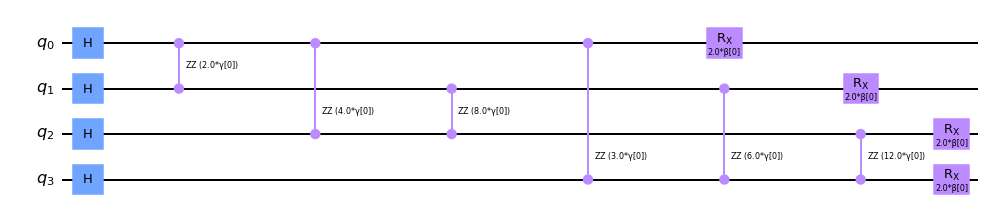

In [8]:
rzz_unrolled.draw("mpl")

In [12]:
from qiskit.quantum_info import Statevector

def energy(values):
    bound_circuit = ansatz.bind_parameters(values)
    # the energy is a real value! also we want to optimize real parameters
    return np.real(Statevector(bound_circuit).expectation_value(hamiltonian.primitive))

_**End solution**_

### Optimize the energy

Now optimize the energy. You could for instance use one of Qiskit's built-in optimizers as

In [13]:
from qiskit.algorithms.optimizers import COBYLA

def example_function(x):
    return (np.linalg.norm(x) - 1) ** 2

example_x0 = np.array([1, 1])  # initial point

example_result = COBYLA().minimize(example_function, example_x0)

print("Minimum at:", example_result.x)
print("Function value:", example_result.fun)

Minimum at: [0.9826468  0.18479216]
Function value: 1.6530767025061928e-08


_**Begin solution**_

In [14]:
def loss_landscape():
    betas = np.linspace(-np.pi / 2, np.pi / 2, 50)
    gammas = np.linspace(-np.pi / 2, np.pi / 2, 50)
    
    losses = [[energy([beta, gamma]) for beta in betas] for gamma in gammas]
    
    X, Y = np.meshgrid(betas, gammas)
    
    return X, Y, losses

X, Y, Z = loss_landscape()

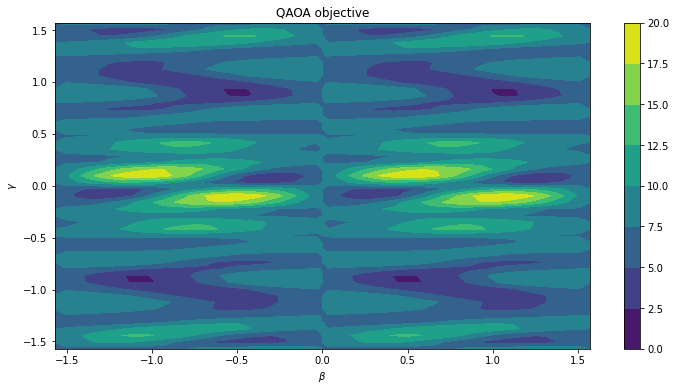

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.contourf(X, Y, Z)
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\gamma$")
plt.title("QAOA objective")
plt.colorbar()

In [17]:
# reference energy
from qiskit.algorithms import NumPyMinimumEigensolver

exact_solver = NumPyMinimumEigensolver()
exact_result = exact_solver.compute_minimum_eigenvalue(hamiltonian)
print("Exact:", exact_result.eigenvalue)

# minimize the energy
from qiskit.algorithms.optimizers import COBYLA

initial_point = np.random.random(ansatz.num_parameters)
# initial_point = np.array([0.1, 0])
# optimizer = SPSA(maxiter=300, learning_rate=0.0001, perturbation=0.01)
optimizer = COBYLA()
result = optimizer.minimize(energy, initial_point)
print("QAOA:", result.fun) 

print(result.x)

Exact: 0j
QAOA: 3.3172417314229423
[0.40769089 1.49141592]


In [18]:
# sampling probability of an optimal solution
optimal_state = Statevector(ansatz.bind_parameters(result.x))
sampling_probabilities = optimal_state.probabilities_dict(decimals=2)

costs = [(state, cost(state, True), probability) for state, probability in sampling_probabilities.items()]

# get optimal states
sorted_by_cost = sorted(costs, key=lambda value: value[1])

print("Best solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_cost[i])
print()

# sort by sampling probability
sorted_by_prob = sorted(costs, key=lambda value: value[2])

print("Most likely solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_prob[~i])


Best solutions:
('0101', 0.0, 0.01)
('1010', 0.0, 0.01)
('0100', 1.0, 0.18)
('0110', 1.0, 0.17)
('1001', 1.0, 0.17)

Most likely solutions:
('1011', 1.0, 0.18)
('0100', 1.0, 0.18)
('1001', 1.0, 0.17)
('0110', 1.0, 0.17)
('1101', 9.0, 0.12)


#### Starting from an annealing schedule

In [19]:
p = 5
ansatz = QAOAAnsatz(hamiltonian, reps=p)

def energy(values):
    bound_circuit = ansatz.bind_parameters(values)
    # the energy is a real value! also we want to optimize real parameters
    return np.real(Statevector(bound_circuit).expectation_value(hamiltonian.primitive))

In [20]:
T = 6
beta = (1 - np.arange(1, p + 1) / p) * T / p
gamma = T / p * np.arange(1, p + 1) / p

In [21]:
initial_point = np.concatenate((beta, gamma))
# initial_point = np.array([0.1, 0])
# optimizer = SPSA(maxiter=300, learning_rate=0.0001, perturbation=0.01)
optimizer = COBYLA()
result = optimizer.minimize(energy, initial_point)
print("QAOA:", result.fun) 

print(result.x)

QAOA: 0.7044404442965506
[1.08490082 0.78862621 1.57658869 0.43140288 0.90262518 1.30296601
 0.37615383 0.76018599 0.97309631 1.18596731]


In [22]:
# sampling probability of an optimal solution
optimal_state = Statevector(ansatz.bind_parameters(result.x))
sampling_probabilities = optimal_state.probabilities_dict(decimals=2)

costs = [(state, cost(state, True), probability) for state, probability in sampling_probabilities.items()]

# get optimal states
sorted_by_cost = sorted(costs, key=lambda value: value[1])

print("Best solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_cost[i])
print()

# sort by sampling probability
sorted_by_prob = sorted(costs, key=lambda value: value[2])

print("Most likely solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_prob[~i])

Best solutions:
('0101', 0.0, 0.29)
('1010', 0.0, 0.29)
('0100', 1.0, 0.02)
('0110', 1.0, 0.15)
('1001', 1.0, 0.15)

Most likely solutions:
('1010', 0.0, 0.29)
('0101', 0.0, 0.29)
('1001', 1.0, 0.15)
('0110', 1.0, 0.15)
('1011', 1.0, 0.02)


_**End solution**_

**Expected result** The optimal solutions should be at least among the 5 most likely states and have a probability distinctively larger than $1 / 2^\text{n}$, where $n$ is the number of qubits.

### TODO Warmstarting

In [23]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CplexOptimizer

In [24]:
qaoa_mes = QAOA(quantum_instance=AerSimulator(), include_custom=True, initial_point=[0.0, 1.0])
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.0
)

NameError: name 'QAOA' is not defined

In [ ]:
sol = ws_qaoa.solve(qubo)

### CVaR expectation

Update your energy evaluation such that only the best $\alpha \in (0, 1]$ fraction of the shots contribute to the expectation value.

In [ ]:
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms import QAOA
from qiskit.opflow import CVaRExpectation
from qiskit.algorithms.optimizers import *

energies = []
def store_energy(*args):
    energies.append(args[2])

    
# initial_point = np.array([0.5, 1])
# optimizer = SPSA(maxiter=1000, perturbation=0.01, learning_rate=0.00001, callback=store_energy)
optimizer = COBYLA()
expectation = CVaRExpectation(alpha=0.25)
# expectation = None

qaoa = QAOA(optimizer=optimizer, 
            expectation=expectation, 
            include_custom=True,
#             initial_point=initial_point,
            reps=1,
            callback=store_energy,
            quantum_instance=AerSimulator())
result = qaoa.compute_minimum_eigenvalue(hamiltonian)
print("QAOA:", result.eigenvalue)

In [ ]:
result.optimal_point

In [ ]:
import matplotlib.pyplot as plt

plt.plot(energies)

In [ ]:
optimal_state = Statevector(ansatz.bind_parameters(result.optimal_point))
sampling_probabilities = optimal_state.probabilities_dict(decimals=2)

costs = [(state, cost(state, True), probability) for state, probability in sampling_probabilities.items()]

# get optimal states
sorted_by_cost = sorted(costs, key=lambda value: value[1])

print("Best solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_cost[i])
print()

# sort by sampling probability
sorted_by_prob = sorted(costs, key=lambda value: value[2])

print("Most likely solutions:")
for i in range(min(5, len(costs))):
    print(sorted_by_prob[~i])

## C. Circuit optimization

Now we'll transpile the circuit for the ``ibmq_quito`` device.

In [ ]:
from qiskit.test.mock import FakeQuito
backend = FakeQuito()

# or for the actual device, if you have an IBM Quantum Experience account
# from qiskit import IBMQ
# IBMQ.load_account()
# provider = IBMQ.get_provider(group="open")
# backend = provider.get_backend("ibmq_quito")

_**Begin solution**_

In [ ]:
from qiskit import transpile

ansatz = QAOAAnsatz(hamiltonian, reps=1)

values = [0.2, 0.5]
bound = ansatz.bind_parameters(values)
transpiled = transpile(bound, backend, optimization_level=1)
transpiled.draw("mpl", style="iqx")

In [ ]:
num_cx = transpiled.count_ops()["cx"]
cx_fidelity = 1 - 1.047e-2

expected_fidelity = cx_fidelity ** num_cx
print(expected_fidelity)

### Pulse efficient decomposition

*Note: This works correctly only for a circuit with bound parameters.*

In [ ]:
from qiskit import schedule

schedule(transpiled, backend).draw()

In [ ]:
from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks, ConsolidateBlocks, EchoRZXWeylDecomposition, RZXCalibrationBuilderNoEcho,
    UnrollCustomDefinitions, BasisTranslator, Optimize1qGatesDecomposition
)

# Build the pass manager for the parameterized circuit
rzx_basis = ['rzx', 'rz', 'x', 'sx']

# Build a pass manager for the CX decomposition (works only on bound circuits)
pm = PassManager([
  # Consolidate consecutive two-qubit operations.
  Collect2qBlocks(),
  ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),

  # Rewrite circuit in terms of Weyl-decomposed echoed RZX gates.
  EchoRZXWeylDecomposition(backend.defaults().instruction_schedule_map),

  # Attach scaled CR pulse schedules to the RZX gates.
  RZXCalibrationBuilderNoEcho(backend),

  # Simplify single-qubit gates.
  UnrollCustomDefinitions(std_eqlib, rzx_basis),
  BasisTranslator(std_eqlib, rzx_basis),
  Optimize1qGatesDecomposition(rzx_basis),
])

In [ ]:
rzx_efficient = pm.run(transpiled)

In [ ]:
schedule(rzx_efficient, backend).draw()

In [ ]:
rzx_efficient.draw("mpl")

In [ ]:
print("Reduction by a factor of:", end=" ")
print(schedule(transpiled, backend).duration / schedule(rzx_efficient, backend).duration)

In [ ]:
backend_options = {"backend_name": "ibmq_manila"}

inputs = {
    "reps": 2,
    ..
}

job = prov.runtime.run(
    job_id="qaoa",
    inputs=inputs,
    options=backend_options,
    callback=callback
)